In [1]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attempt

In [3]:
os.listdir('/kaggle/input/soil-classification/soil_classification-2025/train')[:5]

['img_3c4ed833.jpeg',
 'img_8163dc71.jpg',
 'img_e48dfef4.jpg',
 'img_83d433d2.jpg',
 'img_4b62f891.jpeg']

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [5]:
train = pd.read_csv('/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv')

display(train.head())

,image_id,soil_type
0,img_ed005410.jpg,Alluvial soil
1,img_0c5ecd2a.jpg,Alluvial soil
2,img_ed713bb5.jpg,Alluvial soil
3,img_12c58874.jpg,Alluvial soil
4,img_eff357af.jpg,Alluvial soil


In [6]:
le = LabelEncoder()
train["label_encoded"] = le.fit_transform(train["soil_type"])

In [7]:
display(train.head())

,image_id,soil_type,label_encoded
0,img_ed005410.jpg,Alluvial soil,0
1,img_0c5ecd2a.jpg,Alluvial soil,0
2,img_ed713bb5.jpg,Alluvial soil,0
3,img_12c58874.jpg,Alluvial soil,0
4,img_eff357af.jpg,Alluvial soil,0


In [8]:
train["label"] = train["soil_type"]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


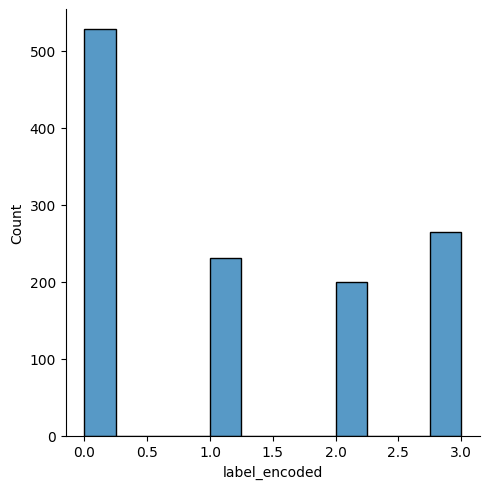

In [9]:
sns.displot(train['label_encoded'], kde=False)

In [10]:
train["soil_type"].value_counts()

soil_type
Alluvial soil    528
Red soil         264
Black Soil       231
Clay soil        199
Name: count, dtype: int64

In [11]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '/kaggle/input/soil-classification/soil_classification-2025/train'
TEST_PATH = '/kaggle/input/soil-classification/soil_classification-2025/test'

In [12]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    model_name='tf_efficientnet_b5_ns'  #'resnext50_32x4d'
    size=512
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=10
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=8
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=4
    target_col='label_encoded'
    n_fold=5
    trn_fold=[0,1,2,3,4]
    train=True
    inference=False
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [13]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import *
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

if CFG.apex:
    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [14]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return f1_score(y_true, y_pred,average='macro')


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [15]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  label_encoded
0     0                106
      1                 46
      2                 40
      3                 53
1     0                106
      1                 47
      2                 40
      3                 52
2     0                106
      1                 46
      2                 39
      3                 53
3     0                105
      1                 46
      2                 40
      3                 53
4     0                105
      1                 46
      2                 40
      3                 53
dtype: int64


In [16]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label_encoded'].values
        self.foldername = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        folder_name = self.foldername[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image_id']
        return image

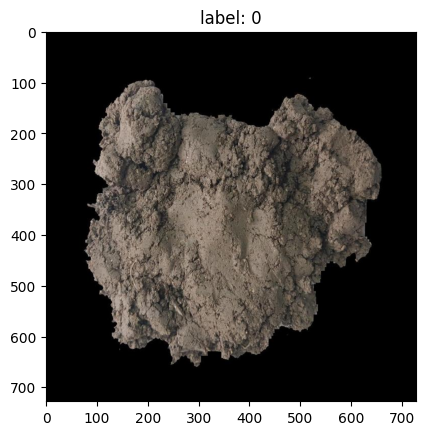

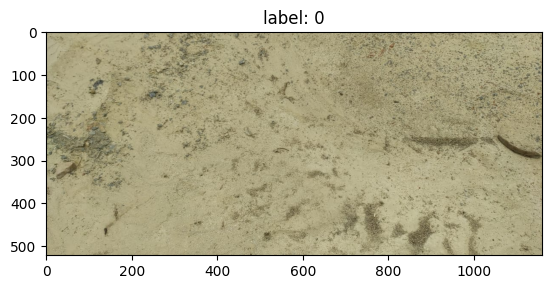

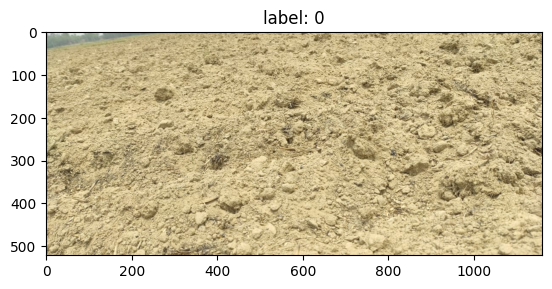

In [17]:
train_dataset = TrainDataset(train, transform=None)

for i in range(3):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

In [18]:
CFG.size

512

In [19]:
from albumentations import Resize

In [20]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop((CFG.size, CFG.size)),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [21]:
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG.model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [22]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

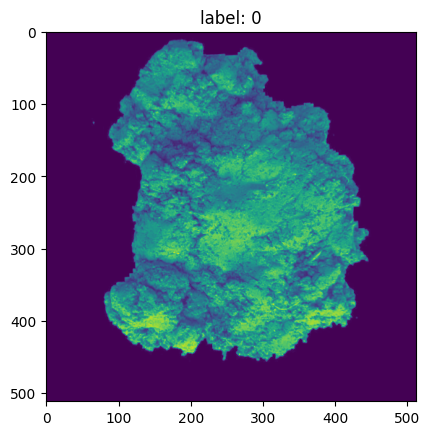

In [23]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [24]:
model = CustomEfficientNet(model_name=CFG.model_name, pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[-0.1019,  0.0834,  0.0167,  0.1015],
        [-0.5224, -0.0444, -0.2946,  0.8424],
        [-0.0016,  0.0856,  0.0366, -0.0176],
        [ 0.0020,  0.0887,  0.0369, -0.0113]], grad_fn=<AddmmBackward0>)


In [25]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [26]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomEfficientNet(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - F1 SCORE: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth',weights_only = False)
    print( len(check_point['preds']))

    valid_folds[[str(c) for c in range(4)]] = check_point['preds']
    
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds


In [27]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    
    if CFG.inference:
        # inference
        model = CustomResNext(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                                 num_workers=CFG.num_workers, pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)
if __name__ == '__main__':
    main()

========== fold: 0 training ==========


model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

Epoch: [1][0/122] Data 0.646 (0.646) Elapsed 0m 2s (remain 4m 52s) Loss: 1.4175(1.4175) Grad: 3.6003  
Epoch: [1][100/122] Data 0.000 (0.007) Elapsed 1m 15s (remain 0m 15s) Loss: 0.5853(0.6661) Grad: 5.3272  
Epoch: [1][121/122] Data 0.000 (0.009) Elapsed 1m 31s (remain 0m 0s) Loss: 0.1317(0.6259) Grad: 1.7691  
EVAL: [0/31] Data 0.603 (0.603) Elapsed 0m 0s (remain 0m 24s) Loss: 0.1968(0.1968) 


Epoch 1 - avg_train_loss: 0.6259  avg_val_loss: 0.3295  time: 99s
Epoch 1 - F1 SCORE: 0.9040366219056564
Epoch 1 - Save Best Score: 0.9040 Model


EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.1934(0.3295) 
Epoch: [2][0/122] Data 0.540 (0.540) Elapsed 0m 0s (remain 1m 41s) Loss: 0.5140(0.5140) Grad: 4.4303  
Epoch: [2][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.2712(0.3759) Grad: 3.6056  
Epoch: [2][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.4931(0.3634) Grad: 4.6450  
EVAL: [0/31] Data 0.599 (0.599) Elapsed 0m 0s (remain 0m 23s) Loss: 0.1091(0.1091) 


Epoch 2 - avg_train_loss: 0.3634  avg_val_loss: 0.2577  time: 98s
Epoch 2 - F1 SCORE: 0.9138546151422872
Epoch 2 - Save Best Score: 0.9139 Model


EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.1233(0.2577) 
Epoch: [3][0/122] Data 0.532 (0.532) Elapsed 0m 0s (remain 1m 41s) Loss: 0.1819(0.1819) Grad: 3.1172  
Epoch: [3][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.2724(0.2775) Grad: 4.6605  
Epoch: [3][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.2572(0.2963) Grad: 3.1332  
EVAL: [0/31] Data 0.533 (0.533) Elapsed 0m 0s (remain 0m 21s) Loss: 0.0368(0.0368) 


Epoch 3 - avg_train_loss: 0.2963  avg_val_loss: 0.2119  time: 99s
Epoch 3 - F1 SCORE: 0.9460325634603617
Epoch 3 - Save Best Score: 0.9460 Model


EVAL: [30/31] Data 0.000 (0.017) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0880(0.2119) 
Epoch: [4][0/122] Data 0.514 (0.514) Elapsed 0m 0s (remain 1m 39s) Loss: 0.1512(0.1512) Grad: 2.5844  
Epoch: [4][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0585(0.2101) Grad: 1.7859  
Epoch: [4][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.1188(0.2139) Grad: 2.1386  
EVAL: [0/31] Data 0.597 (0.597) Elapsed 0m 0s (remain 0m 23s) Loss: 0.0855(0.0855) 


Epoch 4 - avg_train_loss: 0.2139  avg_val_loss: 0.1924  time: 99s
Epoch 4 - F1 SCORE: 0.9235337617546626


EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.2446(0.1924) 
Epoch: [5][0/122] Data 0.542 (0.542) Elapsed 0m 0s (remain 1m 43s) Loss: 0.2432(0.2432) Grad: 2.9285  
Epoch: [5][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.2668(0.1947) Grad: 4.2792  
Epoch: [5][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0982(0.1894) Grad: 3.1465  
EVAL: [0/31] Data 0.609 (0.609) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0031(0.0031) 


Epoch 5 - avg_train_loss: 0.1894  avg_val_loss: 0.1617  time: 99s
Epoch 5 - F1 SCORE: 0.9342492535122395


EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.1835(0.1617) 
Epoch: [6][0/122] Data 0.531 (0.531) Elapsed 0m 0s (remain 1m 42s) Loss: 0.0620(0.0620) Grad: 1.2965  
Epoch: [6][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.1274(0.1887) Grad: 2.7948  
Epoch: [6][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0461(0.1711) Grad: 1.5878  
EVAL: [0/31] Data 0.612 (0.612) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0303(0.0303) 
EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0608(0.1331) 


Epoch 6 - avg_train_loss: 0.1711  avg_val_loss: 0.1331  time: 99s
Epoch 6 - F1 SCORE: 0.9466616031539279
Epoch 6 - Save Best Score: 0.9467 Model


Epoch: [7][0/122] Data 0.570 (0.570) Elapsed 0m 0s (remain 1m 47s) Loss: 0.0545(0.0545) Grad: 1.1127  
Epoch: [7][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.4251(0.1163) Grad: 6.9908  
Epoch: [7][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.1703(0.1068) Grad: 6.3648  
EVAL: [0/31] Data 0.557 (0.557) Elapsed 0m 0s (remain 0m 22s) Loss: 0.0253(0.0253) 


Epoch 7 - avg_train_loss: 0.1068  avg_val_loss: 0.1354  time: 99s
Epoch 7 - F1 SCORE: 0.9535490432084004
Epoch 7 - Save Best Score: 0.9535 Model


EVAL: [30/31] Data 0.000 (0.018) Elapsed 0m 6s (remain 0m 0s) Loss: 0.1169(0.1354) 
Epoch: [8][0/122] Data 0.545 (0.545) Elapsed 0m 0s (remain 1m 42s) Loss: 0.0442(0.0442) Grad: 1.2821  
Epoch: [8][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0297(0.1260) Grad: 0.8813  
Epoch: [8][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0482(0.1281) Grad: 1.5290  
EVAL: [0/31] Data 0.559 (0.559) Elapsed 0m 0s (remain 0m 22s) Loss: 0.0568(0.0568) 
EVAL: [30/31] Data 0.000 (0.018) Elapsed 0m 6s (remain 0m 0s) Loss: 0.1221(0.1361) 


Epoch 8 - avg_train_loss: 0.1281  avg_val_loss: 0.1361  time: 99s
Epoch 8 - F1 SCORE: 0.9480612755574234


Epoch: [9][0/122] Data 0.534 (0.534) Elapsed 0m 0s (remain 1m 41s) Loss: 0.0353(0.0353) Grad: 1.0035  
Epoch: [9][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0167(0.1353) Grad: 0.4222  
Epoch: [9][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.1493(0.1351) Grad: 3.0216  
EVAL: [0/31] Data 0.542 (0.542) Elapsed 0m 0s (remain 0m 22s) Loss: 0.0162(0.0162) 


Epoch 9 - avg_train_loss: 0.1351  avg_val_loss: 0.1328  time: 99s
Epoch 9 - F1 SCORE: 0.9614601249739797
Epoch 9 - Save Best Score: 0.9615 Model


EVAL: [30/31] Data 0.000 (0.018) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0879(0.1328) 
Epoch: [10][0/122] Data 0.477 (0.477) Elapsed 0m 0s (remain 1m 35s) Loss: 0.2946(0.2946) Grad: 5.2238  
Epoch: [10][100/122] Data 0.000 (0.009) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0928(0.1174) Grad: 3.2910  
Epoch: [10][121/122] Data 0.000 (0.011) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0117(0.1054) Grad: 0.3007  
EVAL: [0/31] Data 0.551 (0.551) Elapsed 0m 0s (remain 0m 22s) Loss: 0.0533(0.0533) 


Epoch 10 - avg_train_loss: 0.1054  avg_val_loss: 0.1453  time: 98s
Epoch 10 - F1 SCORE: 0.9496435668689641


EVAL: [30/31] Data 0.000 (0.018) Elapsed 0m 6s (remain 0m 0s) Loss: 0.1062(0.1453) 


========== fold: 0 result ==========
Score: 0.96146
========== fold: 1 training ==========


245
Epoch: [1][0/122] Data 0.626 (0.626) Elapsed 0m 1s (remain 2m 48s) Loss: 1.4205(1.4205) Grad: 3.7378  
Epoch: [1][100/122] Data 0.000 (0.006) Elapsed 1m 15s (remain 0m 15s) Loss: 0.4568(0.6309) Grad: 5.8389  
Epoch: [1][121/122] Data 0.000 (0.009) Elapsed 1m 31s (remain 0m 0s) Loss: 0.4831(0.6006) Grad: 3.8995  
EVAL: [0/31] Data 0.605 (0.605) Elapsed 0m 0s (remain 0m 23s) Loss: 0.3171(0.3171) 


Epoch 1 - avg_train_loss: 0.6006  avg_val_loss: 0.3640  time: 99s
Epoch 1 - F1 SCORE: 0.882217175571415
Epoch 1 - Save Best Score: 0.8822 Model


EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0882(0.3640) 
Epoch: [2][0/122] Data 0.586 (0.586) Elapsed 0m 0s (remain 1m 47s) Loss: 0.5492(0.5492) Grad: 6.8499  
Epoch: [2][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0959(0.3470) Grad: 2.4668  
Epoch: [2][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.8004(0.3470) Grad: 5.7874  
EVAL: [0/31] Data 0.673 (0.673) Elapsed 0m 0s (remain 0m 25s) Loss: 0.1884(0.1884) 


Epoch 2 - avg_train_loss: 0.3470  avg_val_loss: 0.2299  time: 99s
Epoch 2 - F1 SCORE: 0.9176861948103073
Epoch 2 - Save Best Score: 0.9177 Model


EVAL: [30/31] Data 0.000 (0.022) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0839(0.2299) 
Epoch: [3][0/122] Data 0.599 (0.599) Elapsed 0m 0s (remain 1m 50s) Loss: 0.5845(0.5845) Grad: 7.3814  
Epoch: [3][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.3035(0.3131) Grad: 3.8518  
Epoch: [3][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.3830(0.3135) Grad: 4.6325  
EVAL: [0/31] Data 0.639 (0.639) Elapsed 0m 0s (remain 0m 25s) Loss: 0.0059(0.0059) 


Epoch 3 - avg_train_loss: 0.3135  avg_val_loss: 0.1606  time: 99s
Epoch 3 - F1 SCORE: 0.9301732175515778
Epoch 3 - Save Best Score: 0.9302 Model


EVAL: [30/31] Data 0.000 (0.021) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0187(0.1606) 
Epoch: [4][0/122] Data 0.579 (0.579) Elapsed 0m 0s (remain 1m 47s) Loss: 0.2753(0.2753) Grad: 3.0663  
Epoch: [4][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.1773(0.2445) Grad: 3.1868  
Epoch: [4][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.2241(0.2462) Grad: 4.1638  
EVAL: [0/31] Data 0.765 (0.765) Elapsed 0m 0s (remain 0m 28s) Loss: 0.0389(0.0389) 


Epoch 4 - avg_train_loss: 0.2462  avg_val_loss: 0.1758  time: 99s


EVAL: [30/31] Data 0.000 (0.025) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0252(0.1758) 


Epoch 4 - F1 SCORE: 0.9360267183796596
Epoch 4 - Save Best Score: 0.9360 Model


Epoch: [5][0/122] Data 0.536 (0.536) Elapsed 0m 0s (remain 1m 42s) Loss: 0.1402(0.1402) Grad: 2.7083  
Epoch: [5][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0283(0.1873) Grad: 0.5389  
Epoch: [5][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.6009(0.1859) Grad: 10.3253  
EVAL: [0/31] Data 0.627 (0.627) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0194(0.0194) 


Epoch 5 - avg_train_loss: 0.1859  avg_val_loss: 0.1269  time: 99s
Epoch 5 - F1 SCORE: 0.9677197802197802
Epoch 5 - Save Best Score: 0.9677 Model


EVAL: [30/31] Data 0.000 (0.021) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0035(0.1269) 
Epoch: [6][0/122] Data 0.574 (0.574) Elapsed 0m 0s (remain 1m 48s) Loss: 0.0560(0.0560) Grad: 1.3059  
Epoch: [6][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.1731(0.1665) Grad: 3.0886  
Epoch: [6][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0411(0.1653) Grad: 0.8848  
EVAL: [0/31] Data 0.599 (0.599) Elapsed 0m 0s (remain 0m 23s) Loss: 0.0136(0.0136) 


Epoch 6 - avg_train_loss: 0.1653  avg_val_loss: 0.0950  time: 99s
Epoch 6 - F1 SCORE: 0.9753472681936538
Epoch 6 - Save Best Score: 0.9753 Model


EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0051(0.0950) 
Epoch: [7][0/122] Data 0.553 (0.553) Elapsed 0m 0s (remain 1m 45s) Loss: 0.0770(0.0770) Grad: 1.7909  
Epoch: [7][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0906(0.1304) Grad: 2.7153  
Epoch: [7][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0139(0.1232) Grad: 0.3075  
EVAL: [0/31] Data 0.620 (0.620) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0080(0.0080) 


Epoch 7 - avg_train_loss: 0.1232  avg_val_loss: 0.0948  time: 99s
Epoch 7 - F1 SCORE: 0.9744188636296751


EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0071(0.0948) 
Epoch: [8][0/122] Data 0.566 (0.566) Elapsed 0m 0s (remain 1m 47s) Loss: 0.0168(0.0168) Grad: 0.4783  
Epoch: [8][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0044(0.1245) Grad: 0.1241  
Epoch: [8][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0785(0.1197) Grad: 2.1450  
EVAL: [0/31] Data 0.587 (0.587) Elapsed 0m 0s (remain 0m 23s) Loss: 0.0079(0.0079) 


Epoch 8 - avg_train_loss: 0.1197  avg_val_loss: 0.0943  time: 99s
Epoch 8 - F1 SCORE: 0.97032306739952


EVAL: [30/31] Data 0.000 (0.019) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0135(0.0943) 
Epoch: [9][0/122] Data 0.623 (0.623) Elapsed 0m 0s (remain 1m 53s) Loss: 0.1190(0.1190) Grad: 3.4363  
Epoch: [9][100/122] Data 0.000 (0.011) Elapsed 1m 15s (remain 0m 15s) Loss: 0.2585(0.1212) Grad: 6.3363  
Epoch: [9][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.3152(0.1117) Grad: 6.2207  
EVAL: [0/31] Data 0.621 (0.621) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0052(0.0052) 


Epoch 9 - avg_train_loss: 0.1117  avg_val_loss: 0.0902  time: 99s
Epoch 9 - F1 SCORE: 0.9755928964819602
Epoch 9 - Save Best Score: 0.9756 Model


EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0145(0.0902) 
Epoch: [10][0/122] Data 0.632 (0.632) Elapsed 0m 0s (remain 1m 53s) Loss: 0.0412(0.0412) Grad: 0.8273  
Epoch: [10][100/122] Data 0.000 (0.011) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0879(0.0785) Grad: 1.9454  
Epoch: [10][121/122] Data 0.000 (0.013) Elapsed 1m 31s (remain 0m 0s) Loss: 0.1479(0.0759) Grad: 4.4722  
EVAL: [0/31] Data 0.599 (0.599) Elapsed 0m 0s (remain 0m 23s) Loss: 0.0061(0.0061) 


Epoch 10 - avg_train_loss: 0.0759  avg_val_loss: 0.0871  time: 99s
Epoch 10 - F1 SCORE: 0.9630299644888203


EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0378(0.0871) 


========== fold: 1 result ==========
Score: 0.97559
========== fold: 2 training ==========


245
Epoch: [1][0/122] Data 0.605 (0.605) Elapsed 0m 1s (remain 2m 43s) Loss: 1.3468(1.3468) Grad: 3.5273  
Epoch: [1][100/122] Data 0.000 (0.006) Elapsed 1m 15s (remain 0m 15s) Loss: 0.1527(0.6615) Grad: 2.4687  
Epoch: [1][121/122] Data 0.000 (0.009) Elapsed 1m 31s (remain 0m 0s) Loss: 0.1926(0.6337) Grad: 2.7501  
EVAL: [0/31] Data 0.623 (0.623) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0715(0.0715) 


Epoch 1 - avg_train_loss: 0.6337  avg_val_loss: 0.2503  time: 99s
Epoch 1 - F1 SCORE: 0.9187821880779627
Epoch 1 - Save Best Score: 0.9188 Model


EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0683(0.2503) 
Epoch: [2][0/122] Data 0.585 (0.585) Elapsed 0m 0s (remain 1m 52s) Loss: 0.9321(0.9321) Grad: 7.2171  
Epoch: [2][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.1972(0.3606) Grad: 3.5616  
Epoch: [2][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.1353(0.3598) Grad: 2.2333  
EVAL: [0/31] Data 0.551 (0.551) Elapsed 0m 0s (remain 0m 22s) Loss: 0.0519(0.0519) 


Epoch 2 - avg_train_loss: 0.3598  avg_val_loss: 0.2539  time: 99s
Epoch 2 - F1 SCORE: 0.9146227953459025


EVAL: [30/31] Data 0.000 (0.018) Elapsed 0m 6s (remain 0m 0s) Loss: 0.1632(0.2539) 
Epoch: [3][0/122] Data 0.582 (0.582) Elapsed 0m 0s (remain 1m 47s) Loss: 0.1097(0.1097) Grad: 1.7314  
Epoch: [3][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.3036(0.2803) Grad: 4.2573  
Epoch: [3][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0279(0.2700) Grad: 0.7123  
EVAL: [0/31] Data 0.550 (0.550) Elapsed 0m 0s (remain 0m 22s) Loss: 0.0142(0.0142) 


Epoch 3 - avg_train_loss: 0.2700  avg_val_loss: 0.1688  time: 98s
Epoch 3 - F1 SCORE: 0.9476451904671757
Epoch 3 - Save Best Score: 0.9476 Model


EVAL: [30/31] Data 0.000 (0.018) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0250(0.1688) 
Epoch: [4][0/122] Data 0.583 (0.583) Elapsed 0m 0s (remain 1m 52s) Loss: 0.4016(0.4016) Grad: 4.6505  
Epoch: [4][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 1.4841(0.2731) Grad: 7.4876  
Epoch: [4][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.1604(0.2578) Grad: 3.3904  
EVAL: [0/31] Data 0.568 (0.568) Elapsed 0m 0s (remain 0m 23s) Loss: 0.0159(0.0159) 


Epoch 4 - avg_train_loss: 0.2578  avg_val_loss: 0.1961  time: 99s
Epoch 4 - F1 SCORE: 0.9234793588054457


EVAL: [30/31] Data 0.000 (0.019) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0867(0.1961) 
Epoch: [5][0/122] Data 0.587 (0.587) Elapsed 0m 0s (remain 1m 48s) Loss: 0.0508(0.0508) Grad: 1.4071  
Epoch: [5][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.1349(0.1486) Grad: 3.6062  
Epoch: [5][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0196(0.1657) Grad: 0.3765  
EVAL: [0/31] Data 0.551 (0.551) Elapsed 0m 0s (remain 0m 22s) Loss: 0.0217(0.0217) 


Epoch 5 - avg_train_loss: 0.1657  avg_val_loss: 0.1479  time: 99s
Epoch 5 - F1 SCORE: 0.942801987015542


EVAL: [30/31] Data 0.000 (0.018) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0079(0.1479) 
Epoch: [6][0/122] Data 0.648 (0.648) Elapsed 0m 0s (remain 1m 54s) Loss: 0.0469(0.0469) Grad: 1.2853  
Epoch: [6][100/122] Data 0.000 (0.011) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0799(0.1592) Grad: 1.4441  
Epoch: [6][121/122] Data 0.000 (0.013) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0909(0.1493) Grad: 1.6288  
EVAL: [0/31] Data 0.527 (0.527) Elapsed 0m 0s (remain 0m 21s) Loss: 0.0245(0.0245) 


Epoch 6 - avg_train_loss: 0.1493  avg_val_loss: 0.1197  time: 99s
Epoch 6 - F1 SCORE: 0.9738319872691863
Epoch 6 - Save Best Score: 0.9738 Model


EVAL: [30/31] Data 0.000 (0.017) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0040(0.1197) 
Epoch: [7][0/122] Data 0.641 (0.641) Elapsed 0m 0s (remain 1m 54s) Loss: 0.0376(0.0376) Grad: 1.0412  
Epoch: [7][100/122] Data 0.000 (0.011) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0622(0.1379) Grad: 1.3879  
Epoch: [7][121/122] Data 0.000 (0.013) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0055(0.1361) Grad: 0.1091  
EVAL: [0/31] Data 0.553 (0.553) Elapsed 0m 0s (remain 0m 22s) Loss: 0.0015(0.0015) 


Epoch 7 - avg_train_loss: 0.1361  avg_val_loss: 0.1029  time: 99s
Epoch 7 - F1 SCORE: 0.964202729593375


EVAL: [30/31] Data 0.000 (0.018) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0170(0.1029) 
Epoch: [8][0/122] Data 0.658 (0.658) Elapsed 0m 0s (remain 1m 57s) Loss: 0.4365(0.4365) Grad: 4.8685  
Epoch: [8][100/122] Data 0.000 (0.011) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0272(0.0907) Grad: 0.5675  
Epoch: [8][121/122] Data 0.000 (0.013) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0416(0.0908) Grad: 0.7329  
EVAL: [0/31] Data 0.694 (0.694) Elapsed 0m 0s (remain 0m 26s) Loss: 0.0044(0.0044) 


Epoch 8 - avg_train_loss: 0.0908  avg_val_loss: 0.1124  time: 99s
Epoch 8 - F1 SCORE: 0.954771435784094


EVAL: [30/31] Data 0.000 (0.023) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0089(0.1124) 
Epoch: [9][0/122] Data 0.650 (0.650) Elapsed 0m 0s (remain 1m 55s) Loss: 0.3398(0.3398) Grad: 5.1554  
Epoch: [9][100/122] Data 0.000 (0.011) Elapsed 1m 15s (remain 0m 15s) Loss: 0.1610(0.1069) Grad: 3.1171  
Epoch: [9][121/122] Data 0.000 (0.013) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0087(0.0990) Grad: 0.1837  
EVAL: [0/31] Data 0.528 (0.528) Elapsed 0m 0s (remain 0m 21s) Loss: 0.0038(0.0038) 


Epoch 9 - avg_train_loss: 0.0990  avg_val_loss: 0.1127  time: 99s
Epoch 9 - F1 SCORE: 0.9633285228956835


EVAL: [30/31] Data 0.000 (0.017) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0126(0.1127) 
Epoch: [10][0/122] Data 0.588 (0.588) Elapsed 0m 0s (remain 1m 49s) Loss: 0.0248(0.0248) Grad: 0.6978  
Epoch: [10][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.2229(0.1259) Grad: 6.1129  
Epoch: [10][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0367(0.1162) Grad: 0.9515  
EVAL: [0/31] Data 0.573 (0.573) Elapsed 0m 0s (remain 0m 23s) Loss: 0.0047(0.0047) 


Epoch 10 - avg_train_loss: 0.1162  avg_val_loss: 0.1188  time: 99s
Epoch 10 - F1 SCORE: 0.9675756342423009


EVAL: [30/31] Data 0.000 (0.019) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0124(0.1188) 


========== fold: 2 result ==========
Score: 0.97383
========== fold: 3 training ==========


244
Epoch: [1][0/122] Data 0.569 (0.569) Elapsed 0m 1s (remain 2m 39s) Loss: 1.4376(1.4376) Grad: 4.0018  
Epoch: [1][100/122] Data 0.000 (0.006) Elapsed 1m 15s (remain 0m 15s) Loss: 0.2149(0.6784) Grad: 3.0220  
Epoch: [1][121/122] Data 0.000 (0.009) Elapsed 1m 31s (remain 0m 0s) Loss: 0.1948(0.6242) Grad: 2.5876  
EVAL: [0/31] Data 0.654 (0.654) Elapsed 0m 0s (remain 0m 25s) Loss: 0.0021(0.0021) 


Epoch 1 - avg_train_loss: 0.6242  avg_val_loss: 0.2432  time: 99s
Epoch 1 - F1 SCORE: 0.9397494075067516
Epoch 1 - Save Best Score: 0.9397 Model


EVAL: [30/31] Data 0.000 (0.021) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0643(0.2432) 
Epoch: [2][0/122] Data 0.529 (0.529) Elapsed 0m 0s (remain 1m 44s) Loss: 0.1452(0.1452) Grad: 1.8960  
Epoch: [2][100/122] Data 0.000 (0.009) Elapsed 1m 15s (remain 0m 15s) Loss: 0.4742(0.3813) Grad: 2.4849  
Epoch: [2][121/122] Data 0.000 (0.011) Elapsed 1m 30s (remain 0m 0s) Loss: 1.4452(0.4040) Grad: 8.7770  
EVAL: [0/31] Data 0.585 (0.585) Elapsed 0m 0s (remain 0m 23s) Loss: 0.0117(0.0117) 


Epoch 2 - avg_train_loss: 0.4040  avg_val_loss: 0.2109  time: 98s
Epoch 2 - F1 SCORE: 0.9563448721663732
Epoch 2 - Save Best Score: 0.9563 Model


EVAL: [30/31] Data 0.000 (0.019) Elapsed 0m 6s (remain 0m 0s) Loss: 0.1515(0.2109) 
Epoch: [3][0/122] Data 0.534 (0.534) Elapsed 0m 0s (remain 1m 47s) Loss: 0.1195(0.1195) Grad: 1.8284  
Epoch: [3][100/122] Data 0.000 (0.009) Elapsed 1m 15s (remain 0m 15s) Loss: 0.2085(0.2659) Grad: 3.0544  
Epoch: [3][121/122] Data 0.000 (0.011) Elapsed 1m 31s (remain 0m 0s) Loss: 0.2179(0.2698) Grad: 2.6951  
EVAL: [0/31] Data 0.592 (0.592) Elapsed 0m 0s (remain 0m 23s) Loss: 0.0145(0.0145) 


Epoch 3 - avg_train_loss: 0.2698  avg_val_loss: 0.1429  time: 99s
Epoch 3 - F1 SCORE: 0.961162753841782
Epoch 3 - Save Best Score: 0.9612 Model


EVAL: [30/31] Data 0.000 (0.019) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0803(0.1429) 
Epoch: [4][0/122] Data 0.658 (0.658) Elapsed 0m 0s (remain 1m 56s) Loss: 0.0866(0.0866) Grad: 0.9592  
Epoch: [4][100/122] Data 0.000 (0.011) Elapsed 1m 15s (remain 0m 15s) Loss: 0.1163(0.2035) Grad: 2.2176  
Epoch: [4][121/122] Data 0.000 (0.013) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0836(0.2100) Grad: 2.3717  
EVAL: [0/31] Data 0.610 (0.610) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0028(0.0028) 


Epoch 4 - avg_train_loss: 0.2100  avg_val_loss: 0.1843  time: 99s
Epoch 4 - F1 SCORE: 0.9586879233262579


EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0232(0.1843) 
Epoch: [5][0/122] Data 0.580 (0.580) Elapsed 0m 0s (remain 1m 47s) Loss: 0.0380(0.0380) Grad: 0.6875  
Epoch: [5][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.3822(0.2175) Grad: 5.2021  
Epoch: [5][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.3612(0.2133) Grad: 6.3630  
EVAL: [0/31] Data 0.637 (0.637) Elapsed 0m 0s (remain 0m 25s) Loss: 0.0021(0.0021) 


Epoch 5 - avg_train_loss: 0.2133  avg_val_loss: 0.1747  time: 99s
Epoch 5 - F1 SCORE: 0.9465260578327803


EVAL: [30/31] Data 0.000 (0.021) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0436(0.1747) 
Epoch: [6][0/122] Data 0.604 (0.604) Elapsed 0m 0s (remain 1m 50s) Loss: 0.0480(0.0480) Grad: 0.7912  
Epoch: [6][100/122] Data 0.000 (0.011) Elapsed 1m 15s (remain 0m 15s) Loss: 0.2126(0.1290) Grad: 4.0522  
Epoch: [6][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0177(0.1237) Grad: 0.6036  
EVAL: [0/31] Data 0.658 (0.658) Elapsed 0m 0s (remain 0m 25s) Loss: 0.0008(0.0008) 


Epoch 6 - avg_train_loss: 0.1237  avg_val_loss: 0.1589  time: 99s
Epoch 6 - F1 SCORE: 0.9641500744520548
Epoch 6 - Save Best Score: 0.9642 Model


EVAL: [30/31] Data 0.000 (0.022) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0245(0.1589) 
Epoch: [7][0/122] Data 0.604 (0.604) Elapsed 0m 0s (remain 1m 52s) Loss: 0.0808(0.0808) Grad: 2.5360  
Epoch: [7][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0806(0.1229) Grad: 1.3255  
Epoch: [7][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0888(0.1435) Grad: 2.3769  
EVAL: [0/31] Data 0.605 (0.605) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0000(0.0000) 
EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.3464(0.1293) 


Epoch 7 - avg_train_loss: 0.1435  avg_val_loss: 0.1293  time: 99s
Epoch 7 - F1 SCORE: 0.9564947004029765


Epoch: [8][0/122] Data 0.614 (0.614) Elapsed 0m 0s (remain 1m 57s) Loss: 0.0595(0.0595) Grad: 1.4387  
Epoch: [8][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0664(0.1164) Grad: 1.8760  
Epoch: [8][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.2080(0.1097) Grad: 4.6599  
EVAL: [0/31] Data 0.629 (0.629) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0013(0.0013) 


Epoch 8 - avg_train_loss: 0.1097  avg_val_loss: 0.1299  time: 98s
Epoch 8 - F1 SCORE: 0.9641500744520548


EVAL: [30/31] Data 0.000 (0.021) Elapsed 0m 6s (remain 0m 0s) Loss: 0.1072(0.1299) 
Epoch: [9][0/122] Data 0.612 (0.612) Elapsed 0m 0s (remain 1m 53s) Loss: 0.0744(0.0744) Grad: 2.2736  
Epoch: [9][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0881(0.1000) Grad: 2.3007  
Epoch: [9][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0734(0.1023) Grad: 1.9688  
EVAL: [0/31] Data 0.616 (0.616) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0006(0.0006) 


Epoch 9 - avg_train_loss: 0.1023  avg_val_loss: 0.1255  time: 99s
Epoch 9 - F1 SCORE: 0.9677150192554557
Epoch 9 - Save Best Score: 0.9677 Model


EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.1309(0.1255) 
Epoch: [10][0/122] Data 0.622 (0.622) Elapsed 0m 0s (remain 1m 53s) Loss: 0.0347(0.0347) Grad: 0.8256  
Epoch: [10][100/122] Data 0.000 (0.011) Elapsed 1m 15s (remain 0m 15s) Loss: 0.2052(0.0972) Grad: 3.4225  
Epoch: [10][121/122] Data 0.000 (0.013) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0153(0.0921) Grad: 0.2627  
EVAL: [0/31] Data 0.645 (0.645) Elapsed 0m 0s (remain 0m 25s) Loss: 0.0016(0.0016) 


Epoch 10 - avg_train_loss: 0.0921  avg_val_loss: 0.1415  time: 99s
Epoch 10 - F1 SCORE: 0.9552852661302457


EVAL: [30/31] Data 0.000 (0.021) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0946(0.1415) 


========== fold: 3 result ==========
Score: 0.96772
========== fold: 4 training ==========


244
Epoch: [1][0/122] Data 0.563 (0.563) Elapsed 0m 1s (remain 2m 43s) Loss: 1.3813(1.3813) Grad: 3.7050  
Epoch: [1][100/122] Data 0.000 (0.006) Elapsed 1m 15s (remain 0m 15s) Loss: 0.4181(0.6430) Grad: 4.1769  
Epoch: [1][121/122] Data 0.000 (0.008) Elapsed 1m 31s (remain 0m 0s) Loss: 0.1137(0.6133) Grad: 1.4421  
EVAL: [0/31] Data 0.647 (0.647) Elapsed 0m 0s (remain 0m 25s) Loss: 0.0988(0.0988) 


Epoch 1 - avg_train_loss: 0.6133  avg_val_loss: 0.2482  time: 99s
Epoch 1 - F1 SCORE: 0.9191925053287084
Epoch 1 - Save Best Score: 0.9192 Model


EVAL: [30/31] Data 0.000 (0.021) Elapsed 0m 6s (remain 0m 0s) Loss: 0.1721(0.2482) 
Epoch: [2][0/122] Data 0.606 (0.606) Elapsed 0m 0s (remain 1m 51s) Loss: 0.2847(0.2847) Grad: 2.0788  
Epoch: [2][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.1450(0.3840) Grad: 1.7970  
Epoch: [2][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.7229(0.3839) Grad: 6.0495  
EVAL: [0/31] Data 0.723 (0.723) Elapsed 0m 0s (remain 0m 27s) Loss: 0.0620(0.0620) 


Epoch 2 - avg_train_loss: 0.3839  avg_val_loss: 0.1751  time: 99s
Epoch 2 - F1 SCORE: 0.9500785375465681
Epoch 2 - Save Best Score: 0.9501 Model


EVAL: [30/31] Data 0.000 (0.024) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0500(0.1751) 
Epoch: [3][0/122] Data 0.549 (0.549) Elapsed 0m 0s (remain 1m 43s) Loss: 0.1967(0.1967) Grad: 2.2709  
Epoch: [3][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.8898(0.2724) Grad: 7.1783  
Epoch: [3][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.2161(0.2788) Grad: 2.7143  
EVAL: [0/31] Data 0.614 (0.614) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0232(0.0232) 


Epoch 3 - avg_train_loss: 0.2788  avg_val_loss: 0.1165  time: 99s
Epoch 3 - F1 SCORE: 0.9727283183804922
Epoch 3 - Save Best Score: 0.9727 Model


EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.2879(0.1165) 
Epoch: [4][0/122] Data 0.567 (0.567) Elapsed 0m 0s (remain 1m 48s) Loss: 0.0943(0.0943) Grad: 1.5213  
Epoch: [4][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.1028(0.2169) Grad: 2.5249  
Epoch: [4][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0494(0.2385) Grad: 0.9591  
EVAL: [0/31] Data 0.626 (0.626) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0286(0.0286) 


Epoch 4 - avg_train_loss: 0.2385  avg_val_loss: 0.1054  time: 99s
Epoch 4 - F1 SCORE: 0.9633367513887107


EVAL: [30/31] Data 0.000 (0.021) Elapsed 0m 6s (remain 0m 0s) Loss: 0.1638(0.1054) 
Epoch: [5][0/122] Data 0.681 (0.681) Elapsed 0m 0s (remain 1m 59s) Loss: 0.1028(0.1028) Grad: 2.1754  
Epoch: [5][100/122] Data 0.000 (0.011) Elapsed 1m 15s (remain 0m 15s) Loss: 0.1928(0.1977) Grad: 4.3448  
Epoch: [5][121/122] Data 0.000 (0.013) Elapsed 1m 31s (remain 0m 0s) Loss: 0.5057(0.1986) Grad: 9.5684  
EVAL: [0/31] Data 0.618 (0.618) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0029(0.0029) 


Epoch 5 - avg_train_loss: 0.1986  avg_val_loss: 0.0918  time: 99s
Epoch 5 - F1 SCORE: 0.9753982434406963
Epoch 5 - Save Best Score: 0.9754 Model


EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.9035(0.0918) 
Epoch: [6][0/122] Data 0.526 (0.526) Elapsed 0m 0s (remain 1m 42s) Loss: 0.2273(0.2273) Grad: 4.2038  
Epoch: [6][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.1885(0.1785) Grad: 4.6127  
Epoch: [6][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.2526(0.1703) Grad: 5.2108  
EVAL: [0/31] Data 0.578 (0.578) Elapsed 0m 0s (remain 0m 23s) Loss: 0.0150(0.0150) 


Epoch 6 - avg_train_loss: 0.1703  avg_val_loss: 0.0976  time: 99s
Epoch 6 - F1 SCORE: 0.9653536961733618


EVAL: [30/31] Data 0.000 (0.019) Elapsed 0m 6s (remain 0m 0s) Loss: 0.8768(0.0976) 
Epoch: [7][0/122] Data 0.507 (0.507) Elapsed 0m 0s (remain 1m 40s) Loss: 0.2861(0.2861) Grad: 5.3879  
Epoch: [7][100/122] Data 0.000 (0.009) Elapsed 1m 15s (remain 0m 15s) Loss: 0.1763(0.1397) Grad: 3.3771  
Epoch: [7][121/122] Data 0.000 (0.011) Elapsed 1m 31s (remain 0m 0s) Loss: 0.5188(0.1402) Grad: 7.7657  
EVAL: [0/31] Data 0.630 (0.630) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0304(0.0304) 


Epoch 7 - avg_train_loss: 0.1402  avg_val_loss: 0.0893  time: 98s
Epoch 7 - F1 SCORE: 0.9663832123796124


EVAL: [30/31] Data 0.000 (0.021) Elapsed 0m 6s (remain 0m 0s) Loss: 1.0102(0.0893) 
Epoch: [8][0/122] Data 0.593 (0.593) Elapsed 0m 0s (remain 1m 48s) Loss: 0.0977(0.0977) Grad: 1.9586  
Epoch: [8][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.2988(0.1235) Grad: 5.4397  
Epoch: [8][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0367(0.1217) Grad: 1.0147  
EVAL: [0/31] Data 0.617 (0.617) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0566(0.0566) 
EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.6687(0.0773) 


Epoch 8 - avg_train_loss: 0.1217  avg_val_loss: 0.0773  time: 99s
Epoch 8 - F1 SCORE: 0.9746384688096555


Epoch: [9][0/122] Data 0.606 (0.606) Elapsed 0m 0s (remain 1m 51s) Loss: 0.1140(0.1140) Grad: 3.2246  
Epoch: [9][100/122] Data 0.000 (0.010) Elapsed 1m 15s (remain 0m 15s) Loss: 0.4464(0.1092) Grad: 7.7650  
Epoch: [9][121/122] Data 0.000 (0.012) Elapsed 1m 31s (remain 0m 0s) Loss: 0.0644(0.1103) Grad: 1.9723  
EVAL: [0/31] Data 0.609 (0.609) Elapsed 0m 0s (remain 0m 24s) Loss: 0.0178(0.0178) 


Epoch 9 - avg_train_loss: 0.1103  avg_val_loss: 0.0613  time: 99s
Epoch 9 - F1 SCORE: 0.9858359538784067
Epoch 9 - Save Best Score: 0.9858 Model


EVAL: [30/31] Data 0.000 (0.020) Elapsed 0m 6s (remain 0m 0s) Loss: 0.5885(0.0613) 
Epoch: [10][0/122] Data 0.638 (0.638) Elapsed 0m 0s (remain 1m 54s) Loss: 0.0488(0.0488) Grad: 1.2086  
Epoch: [10][100/122] Data 0.000 (0.011) Elapsed 1m 15s (remain 0m 15s) Loss: 0.0077(0.1237) Grad: 0.1568  
Epoch: [10][121/122] Data 0.000 (0.013) Elapsed 1m 31s (remain 0m 0s) Loss: 0.2357(0.1257) Grad: 6.4344  
EVAL: [0/31] Data 0.688 (0.688) Elapsed 0m 0s (remain 0m 26s) Loss: 0.0497(0.0497) 


Epoch 10 - avg_train_loss: 0.1257  avg_val_loss: 0.0632  time: 99s
Epoch 10 - F1 SCORE: 0.9794157734352161


EVAL: [30/31] Data 0.000 (0.022) Elapsed 0m 6s (remain 0m 0s) Loss: 0.4482(0.0632) 


========== fold: 4 result ==========
Score: 0.98584
========== CV ==========
Score: 0.97284


244
